# Introduction to DataJoint

[DataJoint](https://datajoint.org/) is a free, open-source framework for programming scientific databases and computational data pipelines. 

```
pip install datajoint
```

In [1]:
import datajoint as dj

## Access the schema and helper modules

This notebook assumes you have access to a copy of the SQL database that houses the functional data and the functional data schema repository. Set-up instructions and technical documentation are [here](https://www.microns-explorer.org/cortical-mm3#f-data).

This notebook will go over how to use DataJoint to access the functional data and the contents of the schema. For an overview of how to use CAVE to access the connectomics data, see [here](https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/mm3_intro/SynapseAndAnnotationQuery.ipynb).

In [2]:
%capture
from inhib import inhib_nda as nda
from inhib import func

Loading local settings from pipeline_config.json
Connecting pfahey@at-database.ad.bcm.edu:3306


## ERD

[ERD](https://docs.datajoint.io/python/definition/11-ERD.html) stands for entity relationship diagram. Tables are depicted as nodes and dependencies as directed edges between them.

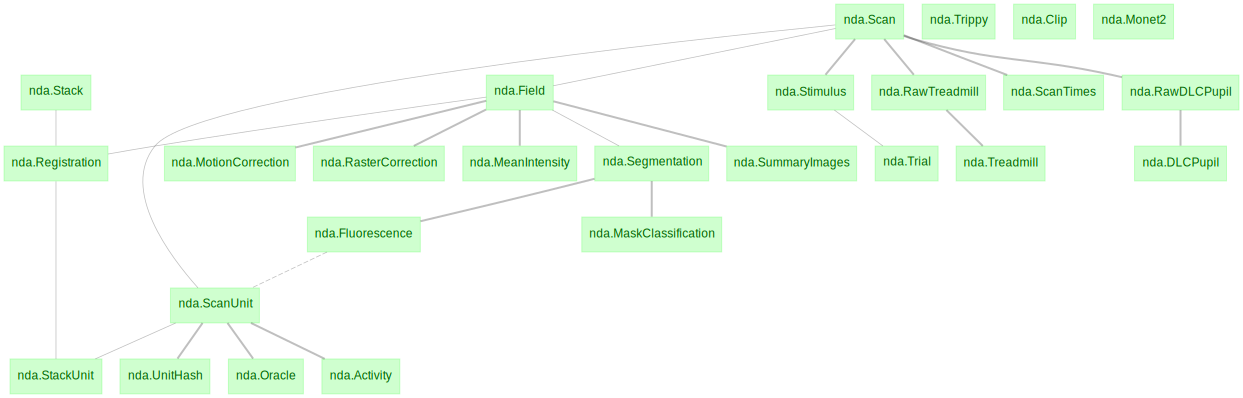

In [3]:
dj.ERD(nda) # View schema ERD

## Basic DataJoint tutorial and data introduction

This tutorial will focus on basic DataJoint usage and introduce the functional data in the schema. 

For detailed information on the contents of the schema, please find our technical documentation [here](https://www.microns-explorer.org/cortical-mm3#f-data). 



### Scan table

Information from the completed scans are located in `nda.Scan`. Access the table by calling:

In [4]:
nda.Scan()

session Session ID,scan_idx Scan ID,nframes number of frames per scan,nfields number of fields per scan,fps frames per second (Hz)
7,5,35337,10,8.08522
7,8,53054,10,8.08522
7,9,53062,10,8.08522
8,5,30497,4,8.99028
8,8,54048,10,8.08522
8,11,23133,10,8.08522
9,5,37151,10,8.08522
9,7,59303,4,8.99028


### Primary keys

[Primary](https://docs.datajoint.io/python/definition/07-Primary-Key.html?) keys are a subset of its attributes that uniquely identify each entity in the table.

In [5]:
[*nda.Scan.heading.primary_key] # primary keys 

['session', 'scan_idx']

### Restrict to a single scan

Dictionaries serve as keys for restricting table entries. Scans are indexed by `session` and `scan_idx`. The `session` attribute is the ID indicating the imaging period for the mouse. `scan_idx` is the index of the scan within the imaging session.

In [6]:
scan_key = {'session': 7, 'scan_idx': 8} 

In [7]:
nda.Scan & scan_key

session Session ID,scan_idx Scan ID,nframes number of frames per scan,nfields number of fields per scan,fps frames per second (Hz)
7,8,53054,10,8.08522


### Restrict to multiple scans

Use a list of dictionaries to restrict to multiple entries.

In [8]:
scan_keys = [{'session': 7, 'scan_idx': 8}, {'session': 7, 'scan_idx': 9}]

In [9]:
nda.Scan & scan_keys

session Session ID,scan_idx Scan ID,nframes number of frames per scan,nfields number of fields per scan,fps frames per second (Hz)
7,8,53054,10,8.08522
7,9,53062,10,8.08522


### Fetch some information from a single scan

The [Fetch](https://docs.datajoint.io/python/queries/03-Fetch.html) methods allow for retrieval of the data within the tables. Use the `fetch1` method to retrieve the contents of the table for a single row. It will error if the restriction yields more than one row. 

In [10]:
nframes, nfields = (nda.Scan & scan_key).fetch1('nframes', 'nfields')
print(f'number of frames in this scan: {nframes}, number of imaging fields in this scan: {nfields}')

number of frames in this scan: 53054, number of imaging fields in this scan: 10


### Fetch some information from multiple scans

Use `fetch` if the restriction yields more than one row. It will return a list for each attribute that is fetched. To fetch all attributes, do not pass any attributes to the `fetch` method

In [11]:
nframes, nfields = (nda.Scan & scan_keys).fetch('nframes', 'nfields')
print(f'number of frames in these scans: {nframes}, number of fields in these scans: {nfields}')

number of frames in these scans: [53054 53062], number of fields in these scans: [10 10]


### Fetch scans keys

Pass in `'KEY'` to `fetch` or `fetch1` to retrieve a list of dictionary keys.

In [12]:
nda.Scan.fetch('KEY')

[{'session': 7, 'scan_idx': 5},
 {'session': 7, 'scan_idx': 8},
 {'session': 7, 'scan_idx': 9},
 {'session': 8, 'scan_idx': 5},
 {'session': 8, 'scan_idx': 8},
 {'session': 8, 'scan_idx': 11},
 {'session': 9, 'scan_idx': 5},
 {'session': 9, 'scan_idx': 7}]

Fetch a single key.

In [13]:
(nda.Scan & scan_key).fetch1('KEY')

{'session': 7, 'scan_idx': 8}

### Field information

Each scan (identified by `session` and `scan_idx`) can have multiple imaging fields. These fields are indexed by the `field` attribute. `nda.Field` containes information for all imaging fields available for a scan.

In [14]:
nda.Field & scan_key

session Session ID,scan_idx Scan ID,field Field Number,px_width field pixels per line,px_height lines per field,um_width field width (microns),um_height field height (microns),field_x field x motor coordinates (microns),field_y field y motor coordinates (microns),field_z field z motor coordinates (microns)
7,8,1,248,248,620.0,620.0,-225.0,-260.0,130.0
7,8,2,248,248,620.0,620.0,-225.0,-260.0,175.0
7,8,3,248,248,620.0,620.0,-225.0,-260.0,220.0
7,8,4,248,248,620.0,620.0,-225.0,-260.0,265.0
7,8,5,248,248,620.0,620.0,-225.0,-260.0,310.0
7,8,6,248,248,620.0,620.0,-225.0,-260.0,355.0
7,8,7,248,248,620.0,620.0,-225.0,-260.0,400.0
7,8,8,248,248,620.0,620.0,-225.0,-260.0,445.0
7,8,9,248,248,620.0,620.0,-225.0,-260.0,490.0
7,8,10,248,248,620.0,620.0,-225.0,-260.0,535.0


Use a `field_key` to restrict to a single entry.

In [15]:
field_key = {'session': 7, 'scan_idx': 8, 'field': 4}

In [16]:
nda.Field & field_key

session Session ID,scan_idx Scan ID,field Field Number,px_width field pixels per line,px_height lines per field,um_width field width (microns),um_height field height (microns),field_x field x motor coordinates (microns),field_y field y motor coordinates (microns),field_z field z motor coordinates (microns)
7,8,4,248,248,620.0,620.0,-225.0,-260.0,265.0


### Frame Times

In [17]:
import numpy as np

The timestamp of each scan frame (in seconds) relative to the start of the scan is located in `nda.FrameTimes`. 

In [18]:
nda.ScanTimes() & scan_key

session Session ID,scan_idx Scan ID,"frame_times stimulus frame times for field 1 of each scan, (len = nframes)",ndepths number of imaging depths recorded for each scan
7,8,=BLOB=,10


The `frame_times` attribute contains the timestamp for each frame synced to the first pixel of the first field (`field 1`) in `nda.Field`.

In [19]:
frame_times = (nda.ScanTimes & scan_key).fetch1('frame_times')
len(frame_times)

53054

`ndepths` contains the number of unique depths across all imaging fields. It can be computed by restricting against the DataJoint [universal set](https://docs.datajoint.io/python/queries/11-Universal-Sets.html) for field depth in the attribute `field_z`. 

In [20]:
nda.Field & scan_key

session Session ID,scan_idx Scan ID,field Field Number,px_width field pixels per line,px_height lines per field,um_width field width (microns),um_height field height (microns),field_x field x motor coordinates (microns),field_y field y motor coordinates (microns),field_z field z motor coordinates (microns)
7,8,1,248,248,620.0,620.0,-225.0,-260.0,130.0
7,8,2,248,248,620.0,620.0,-225.0,-260.0,175.0
7,8,3,248,248,620.0,620.0,-225.0,-260.0,220.0
7,8,4,248,248,620.0,620.0,-225.0,-260.0,265.0
7,8,5,248,248,620.0,620.0,-225.0,-260.0,310.0
7,8,6,248,248,620.0,620.0,-225.0,-260.0,355.0
7,8,7,248,248,620.0,620.0,-225.0,-260.0,400.0
7,8,8,248,248,620.0,620.0,-225.0,-260.0,445.0
7,8,9,248,248,620.0,620.0,-225.0,-260.0,490.0
7,8,10,248,248,620.0,620.0,-225.0,-260.0,535.0


In [21]:
unique_field_depths = dj.U('field_z') & (nda.Field & scan_key)
print(f'The number of unique depths is: {len(unique_field_depths)}')

unique_field_depths

The number of unique depths is: 10


field_z field z motor coordinates (microns)
130.0
175.0
220.0
265.0
310.0
355.0
400.0
445.0
490.0
535.0


You can confirm that the timestamps are at the scan frame frequency by recovering the scan fps. 

In [22]:
fps = (nda.Scan & scan_key).fetch1('fps')
fps

8.08522

In [23]:
(1 / np.diff(frame_times)).mean() # average frequency of timestamps

8.080850110022682

### Stimulus

In [24]:
import matplotlib.pyplot as plt

The movie shown to the mouse for each scan is housed in `nda.Stimulus`. The movie is synced to the timestamps in `nda.ScanTimes`.

In [25]:
nda.Stimulus & scan_key

session Session ID,scan_idx Scan ID,movie stimulus images synchronized with field 1 frame times (H x W X F matrix)
7,8,=BLOB=


In [26]:
movie = (nda.Stimulus & scan_key).fetch1('movie') # stimulus images synchronized with nda.FrameTimes
movie.shape #(height x width x frames)

(90, 160, 53054)

In [27]:
movie_times = (nda.ScanTimes() & scan_key).fetch1('frame_times') # timestamps of stimulus images
movie_times.shape

(53054,)

### Trials

A trial represents a short segment of the stimulus. Trial information is logged in `nda.Trial` and indexed by `trial_idx`. 

There are three types of trials: `Clip`, `Monet2`, and `Trippy`. 

`Clip` types show segments that contain high-entropy scenes such as Hollywood clips, sports clips and rendered movies. 

`Monet2` and `Trippy` types show parametric segments. 

Each stimulus segment has a unique identifier in its `condition_hash` and are indexed in the tables `nda.Clip`, `nda.Monet2`, and `nda.Trippy`. 

`start_idx` and `stop_idx` are the indices of the movie in `nda.Stimulus` during which the trial was ongoing. 

`start_frame_time` and `end_frame_time` are the timestamps of the `start_idx` and `end_idx` in seconds relative to the start of the scan. 

`stim_times` are the timestamps of every frame shown in the movie segment at the original presentation frequency (not synced to the scan). 

In [28]:
nda.Trial & scan_key

session Session ID,scan_idx Scan ID,trial_idx index of trial within stimulus,type type of stimulus trial,start_idx index of field 1 scan frame at start of trial,end_idx index of field 1 scan frame at end of trial,start_frame_time start time of stimulus frame relative to scan start (seconds),end_frame_time end time of stimulus frame relative to scan start (seconds),stim_times full vector of stimulus frame times relative to scan start (seconds),condition_hash 120-bit hash (The first 20 chars of MD5 in base64)
7,8,0,stimulus.Clip,2117,2197,261.96449089050293,271.93102407455444,=BLOB=,Mg5bLgoNvze3EPLB9rbZ
7,8,1,stimulus.Clip,2198,2278,271.9810240268707,281.94755387306213,=BLOB=,yfFAPn1QpVQmEC2iXg07
7,8,2,stimulus.Clip,2279,2359,281.9808762073517,291.94741201400757,=BLOB=,fSfoxctVyPEoVzFOpsAw
7,8,3,stimulus.Clip,2360,2440,291.9807460308075,301.9472770690918,=BLOB=,5Q4+LRPdnmpiazfLNOdJ
7,8,4,stimulus.Clip,2441,2521,301.9972779750824,311.9638090133667,=BLOB=,EyGfkWSsxEsE8f3GX5Ox
7,8,5,stimulus.Clip,2522,2601,311.9971420764923,321.9636631011963,=BLOB=,Lp/pttdcIH1AZsCOGZuG
7,8,6,stimulus.Clip,2602,2682,322.013658285141,331.98019790649414,=BLOB=,9Osy/tmb7E0pJ6H7dUW6
7,8,7,stimulus.Clip,2683,2763,332.01353001594543,341.9800500869751,=BLOB=,rcxCfgMFLR4OgxOPavdo
7,8,8,stimulus.Clip,2764,2844,342.01339507102966,351.9799199104309,=BLOB=,WOP/YibCvfcflS/nd7qh
7,8,9,stimulus.Clip,2845,2925,352.0132579803467,361.9797821044922,=BLOB=,ZZqlqh2+EsiFq5dREu+c


Detailed information about the stimulus during each trial can be obtained by restricting into the appropriate type-specific table. The example trial_key below restricts to a `Monet2` type trial. 

In [29]:
trial_key = {'session': 7, 'scan_idx': 8, 'trial_idx': 12}

In [30]:
trial_info = nda.Trial & trial_key
trial_info

session Session ID,scan_idx Scan ID,trial_idx index of trial within stimulus,type type of stimulus trial,start_idx index of field 1 scan frame at start of trial,end_idx index of field 1 scan frame at end of trial,start_frame_time start time of stimulus frame relative to scan start (seconds),end_frame_time end time of stimulus frame relative to scan start (seconds),stim_times full vector of stimulus frame times relative to scan start (seconds),condition_hash 120-bit hash (The first 20 chars of MD5 in base64)
7,8,12,stimulus.Monet2,3088,3208,382.04618096351624,397.02929520606995,=BLOB=,+rgSVBVRE8Ij1WNhq8ZW


[Join](https://docs.datajoint.io/python/queries/07-Join.html) `trial_info` with `nda.Monet2` using the `*` operator to get all available information about the stimulus during that trial. 

`Monet2` is a directional stimuli, and the vector of directions during the trial is stored in the `directions` attribute. See technical methods for a more detailed description of the contents of this and other stimulus type tables. 

In [31]:
trial_info * nda.Monet2

session Session ID,scan_idx Scan ID,trial_idx index of trial within stimulus,condition_hash 120-bit hash (The first 20 chars of MD5 in base64),type type of stimulus trial,start_idx index of field 1 scan frame at start of trial,end_idx index of field 1 scan frame at end of trial,start_frame_time start time of stimulus frame relative to scan start (seconds),end_frame_time end time of stimulus frame relative to scan start (seconds),stim_times full vector of stimulus frame times relative to scan start (seconds),fps display refresh rate (Hz),duration trial duration (seconds),rng_seed random number generator seed,"blue_green_saturation 0 = grayscale, 1=blue/green",pattern_width width of generated pattern (pixels),pattern_aspect the aspect ratio of generated pattern,"temp_kernel temporal kernel type (hamming, half-hamming)",temp_bandwidth temporal bandwidth of the stimulus (Hz),ori_coherence 1=unoriented noise. pi/ori_coherence = bandwidth of orientation kernel.,ori_fraction fraction of stimulus with coherent orientation vs unoriented,ori_mix mixin-coefficient of orientation biased noise,n_dirs number of directions,"speed (units/s) motion component, where unit is display width",directions computed directions of motion (deg),onsets computed direction onset (seconds),movie rendered uint8 movie (H X W X 1 X T)
7,8,12,+rgSVBVRE8Ij1WNhq8ZW,stimulus.Monet2,3088,3208,382.04618096351624,397.02929520606995,=BLOB=,60.000,15.000,2.0,0.000,72,1.7,hamming,4.00,2.50,1.0,1.0,16,0.2,=BLOB=,=BLOB=,=BLOB=


Use `start_idx` and `end_idx` to view the part of the stimulus corresponding to the trial.

In [32]:
start, end = (trial_info * nda.Monet2).fetch1('start_idx', 'end_idx') # Fetch indices of trial
print(f'Trial starts at index: {start} and ends at index {end}')

Trial starts at index: 3088 and ends at index 3208


In [33]:
stimulus_trial_slice = movie[:,:,slice(start, end)] # slice movie according to indices of trial
stimulus_trial_slice.shape

(90, 160, 120)

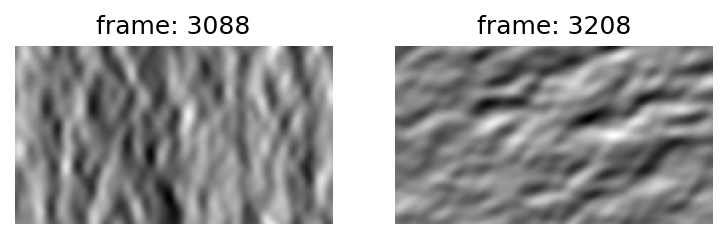

In [34]:
fig, axs = plt.subplots(1, 2, dpi=150) # view first and last frame of movie slice
axs[0].imshow(stimulus_trial_slice[:,:,0], cmap='gray')
axs[0].set_title(f'frame: {start}')
axs[1].imshow(stimulus_trial_slice[:,:,-1], cmap='gray')
axs[1].set_title(f'frame: {end}')
[ax.axis('off') for ax in axs];

### Stimulus from AWS bucket 

The stimulus can also be downloaded from the AWS bucket directly. The stimuli stored on AWS are at 30Hz.

In [71]:
import requests
import skvideo.io

In [72]:
base_url = 'https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/interneuron/functional_data/stimulus_movies'

In [73]:
filename = f'stimulus_21617_{scan_key["session"]}_{scan_key["scan_idx"]}_v1.avi'

In [74]:
url = base_url + '/' + filename
url

'https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/interneuron/functional_data/stimulus_movies/stimulus_21617_7_8_v1.avi'

In [75]:
movie_aws = requests.get(url) # uncomment this cell to download movie. each movie is approx 2GB movie

with open(filename, 'wb') as f:
    f.write(movie_aws.content) # will write to current directory as avi

### Pupil and Treadmill

The pupil radius for each scan is found in `nda.RawDLCPupil` and `nda.DLCPupil`. 

`pupil_min_r` is the smaller of the two radii from the ellipse fit to the pupil and `pupil_maj_r` is the larger radius. 

The tracked position of the pupil is found in `pupil_x` and `pupil_y`. 

`nda.RawDLCPupil` contains the pupil traces and `pupil_times` at the original acquisition rate.

`nda.DLCPupil` contains the pupil traces synced to the `field 1` scan times (found in the `frame_times` attribute in `nda.ScanTimes`)



In [40]:
nda.RawDLCPupil() & scan_key

session Session ID,scan_idx Scan ID,pupil_min_r vector of pupil minor radii (pixels),pupil_maj_r vector of pupil major radii (pixels),pupil_x vector of pupil x positions (pixels),pupil_y vector of pupil y positions (pixels),pupil_times vector of times relative to scan start (seconds)
7,8,=BLOB=,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [41]:
nda.DLCPupil & scan_key

session Session ID,scan_idx Scan ID,pupil_min_r vector of pupil minor radii synchronized with field 1 frame times (pixels),pupil_maj_r vector of pupil major radii synchronized with field 1 frame times (pixels),pupil_x vector of pupil x positions synchronized with field 1 frame times (pixels),pupil_y vector of pupil y positions synchronized with field 1 frame times (pixels)
7,8,=BLOB=,=BLOB=,=BLOB=,=BLOB=


The treadmill velocity for each scan is found in `nda.RawTreadmill` and `nda.Treadmill`.

`nda.RawTreadmill` contains the treadmill velocity trace and timestamps at the original acquisition rate.

`nda.Treadmill` contains the treadmill velocity trace synced to the `field 1` scan times (found in the `field1_times` attribute in `nda.DepthTimes`)

In [42]:
nda.RawTreadmill & scan_key

session Session ID,scan_idx Scan ID,treadmill_velocity vector of treadmill velocities (cm/s),treadmill_timestamps vector of times relative to scan start (seconds)
7,8,=BLOB=,=BLOB=


In [43]:
nda.Treadmill & scan_key

session Session ID,scan_idx Scan ID,treadmill_velocity vector of treadmill velocities synchronized with field 1 frame times (cm/s)
7,8,=BLOB=


### Summary image

A summary image of the field can be found in `nda.SummaryImages`. 

There are two types of images available, `correlation` and `average`. Details of how these are computed can be found in the accompanying methods.

In [44]:
nda.SummaryImages & field_key

session Session ID,scan_idx Scan ID,field Field Number,correlation average image,average correlation image
7,8,4,=BLOB=,=BLOB=


#### Fetch and view images

In [45]:
corr, avg = (nda.SummaryImages & field_key).fetch1('correlation', 'average')

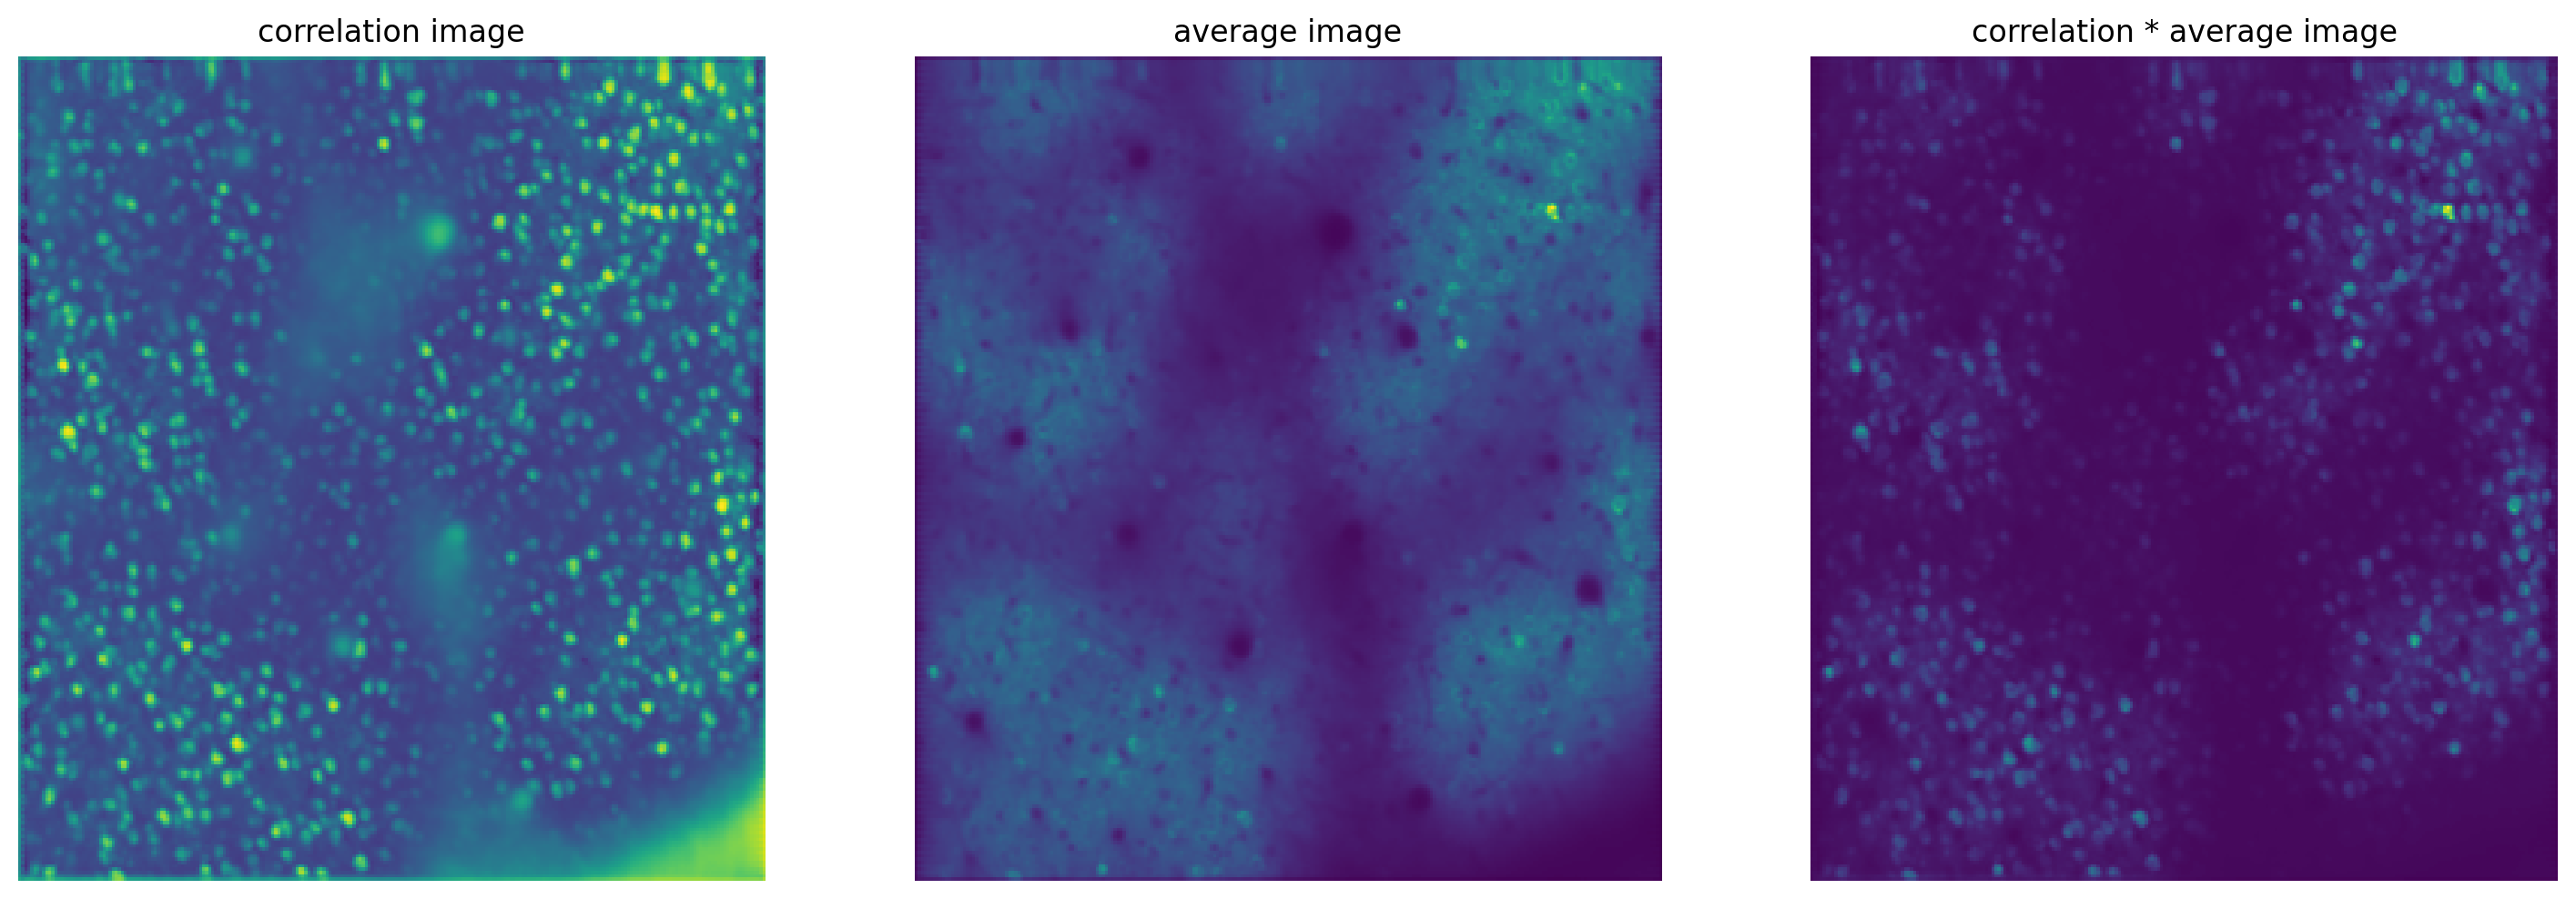

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(18,6), dpi=200)
axs[0].imshow(corr)
axs[0].set_title('correlation image')
axs[1].imshow(avg)
axs[1].set_title('average image')
axs[2].imshow(corr*avg) # gives a good view of the cell bodies and darkens vessels
axs[2].set_title('correlation * average image')
[ax.axis('off') for ax in axs];
[ax.set_aspect('auto') for ax in axs];

### Mean Intensity

The mean intensity of the calcium signal for the entire field is computed per frame for the duration of the scan. This is found in `nda.MeanIntensity`. Periods of low intensity may indicate a low quality stretch of scan, for example where water might have temporarily run out between the microscope objective and imaging site.

In [47]:
intensities = (nda.MeanIntensity & field_key).fetch1('intensities')

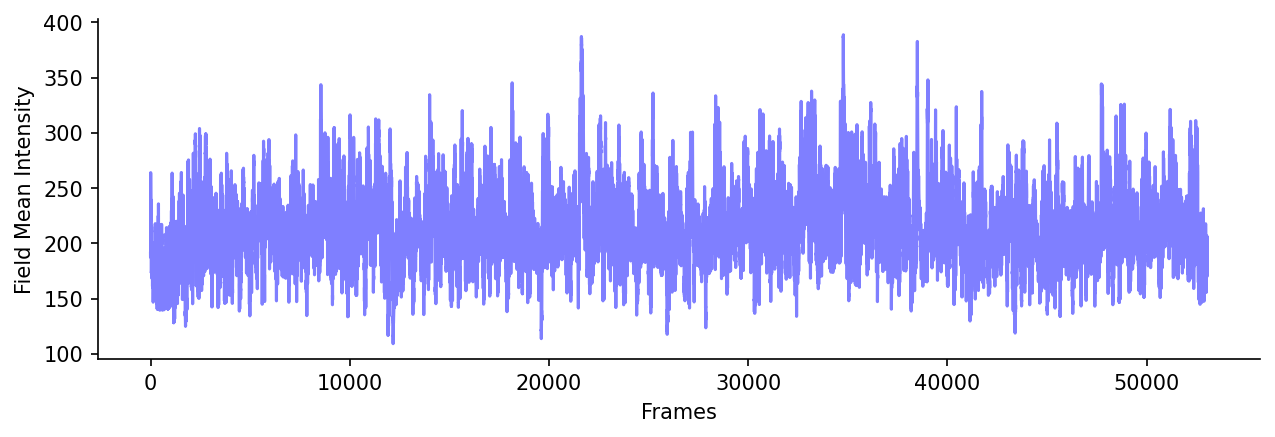

In [48]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(intensities, c='b', alpha=0.5)
ax.set_xlabel('Frames')
ax.set_ylabel('Field Mean Intensity')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Masks

The functional ROI segmentation gives a set of 2D masks indexed by `mask_id`, which are unique per `field`. A cell that was scanned in more than one imaging field will have more than one mask. Masks are stored in `nda.Segmentation`. Classification of masks as `soma` or `artifact` is stored in `nda.MaskClassification`. See technical documentation for further details on segmentation and classification methods.

In [49]:
nda.Segmentation * nda.MaskClassification & field_key

session Session ID,scan_idx Scan ID,field Field Number,"mask_id mask ID, unique per field",pixels indices into the image in column major (Fortran) order,weights weights of the mask at the indices above,mask_type classification of mask as soma or artifact
7,8,4,1,=BLOB=,=BLOB=,soma
7,8,4,2,=BLOB=,=BLOB=,soma
7,8,4,3,=BLOB=,=BLOB=,soma
7,8,4,4,=BLOB=,=BLOB=,soma
7,8,4,5,=BLOB=,=BLOB=,soma
7,8,4,6,=BLOB=,=BLOB=,soma
7,8,4,7,=BLOB=,=BLOB=,soma
7,8,4,8,=BLOB=,=BLOB=,soma
7,8,4,9,=BLOB=,=BLOB=,soma
7,8,4,10,=BLOB=,=BLOB=,soma


Fetch masks and plot over the summary image to view them. 

*Note: the image below is intended to show the density and location of masks, but to better visualize the shape and weights of individual masks, plot them one at a time. A visualization to this effect will be added in a future iteration of this tutorial.*

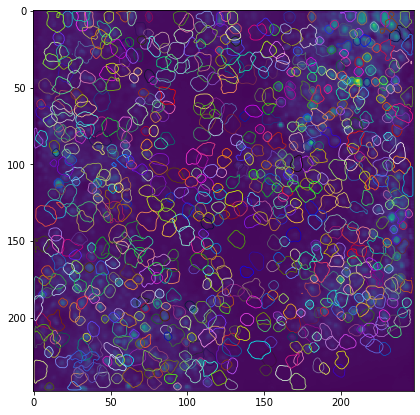

In [50]:
masks = func.get_all_masks(field_key, mask_type='soma', plot=True) # function that will retrieve masks in convenient format and optionally plot

### Calcium fluorescence traces

Each mask has a GCaMP6 fluorescence trace in `nda.Fluorescence`.

In [51]:
calcium_trace = (nda.Fluorescence() & field_key & {'mask_id': 500}).fetch1('trace')

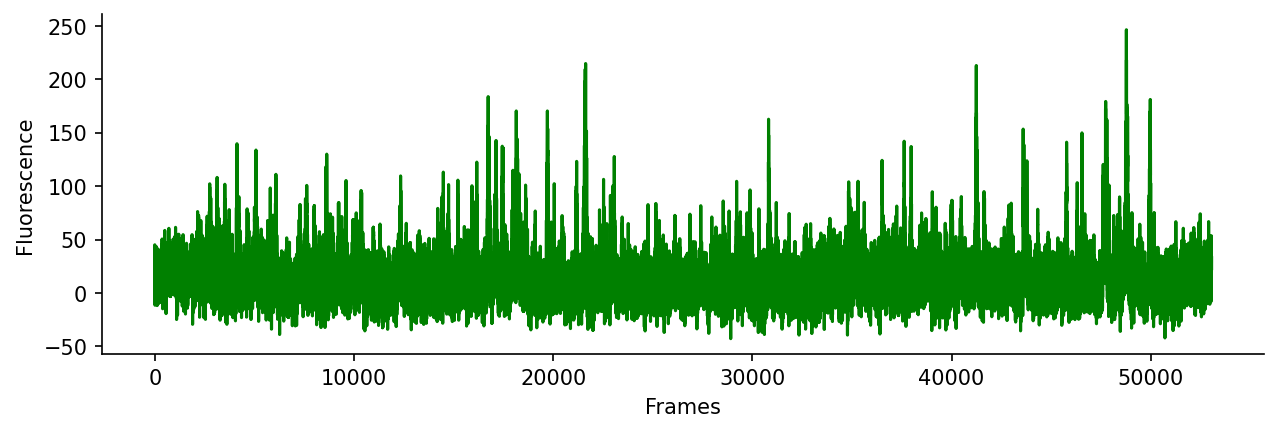

In [52]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(calcium_trace, c='g')
ax.set_xlabel('Frames')
ax.set_ylabel('Fluorescence')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### Single unit information

For the purposes of this schema, a `unit` is a re-indexing of all masks across all imaging fields of a scan and indexed by `unit_id`. `unit_id` is unique per scan.

Note: `unit_id` is not a consolidation step, only re-indexing. Therefore, if a cell was scanned in multiple imaging fields within the scan, just as it had multiple `mask_id's`, it will also have multiple `unit_id's`. 

Information for all units in the scan can be found in `nda.ScanUnit`. This table can be used to relate `mask_id` to its `unit_id`.  

In [53]:
# unit coordinates (`um_x`, `um_y`, `um_z`) are in microns and in the original motor reference frame (see technical documentation for more info)
# unit coordinate (`px_x` and `px_y` are the unit coordinates in image pixels)
# this table can also be used to relate `unit_id's` and `mask_id's` that are used in nda.Segmentation and nda.Fluorescence
nda.ScanUnit() & scan_key

session Session ID,scan_idx Scan ID,unit_id unique per scan,field Field Number,"mask_id mask ID, unique per field",um_x centroid x motor coordinates (microns),um_y centroid y motor coordinates (microns),um_z centroid z motor coordinates (microns),px_x centroid x pixel coordinate in field (pixels,px_y centroid y pixel coordinate in field (pixels,ms_delay delay from start of frame (field 1 pixel 1) to recording of this unit (milliseconds)
7,8,1593,1,1,-522,-549,130,5,9,0
7,8,1594,1,2,-508,-555,130,11,6,0
7,8,1595,1,3,-461,-550,130,29,8,0
7,8,1596,1,4,-448,-557,130,35,5,0
7,8,1597,1,5,-435,-540,130,40,12,1
7,8,1598,1,6,-433,-554,130,41,7,0
7,8,1599,1,7,-436,-546,130,40,10,0
7,8,1600,1,8,-402,-542,130,53,11,0
7,8,1601,1,9,-388,-535,130,59,14,1
7,8,1602,1,10,-411,-564,130,50,3,0


### Oracle score 

The oracle score is a leave-one-out correlation for repeated segments of stimulus. It provides an estimate of visual response reliability for a given unit over the course of the scan. For more detail see the technical documentation found [here](https://www.microns-explorer.org/cortical-mm3#f-data).

Oracle scores are found in `nda.Oracle`. 

*Note that only masks classified as "soma" in `nda.MaskClassification` currently have oracle scores computed. This may change in a future version.*

In [54]:
oracles = (nda.Oracle & scan_key).fetch('pearson')

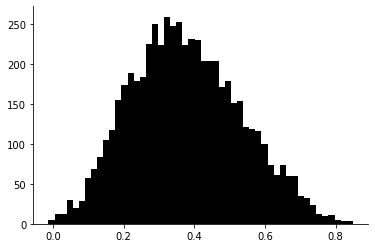

In [55]:
fig, ax = plt.subplots()
ax.hist(oracles, bins=50, color='k');
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [56]:
high_oracle_percentile = np.percentile(oracles, 99)

Oracle scores greater than a threshold value can be specified by restricting the table with a string: `'pearson>x'` where `x` is the oracle value threshold.

In [57]:
high_oracle_table = nda.Oracle & scan_key & f'pearson>{high_oracle_percentile}'
high_oracle_table

session Session ID,scan_idx Scan ID,unit_id unique per scan,trials number of trials used,pearson per unit oracle pearson correlation over all movies
7,8,49,60,0.780276
7,8,136,60,0.738693
7,8,144,60,0.765421
7,8,215,60,0.773293
7,8,228,60,0.738003
7,8,245,60,0.799017
7,8,405,60,0.818085
7,8,430,60,0.843561
7,8,463,60,0.751858
7,8,477,60,0.737322


Select the nth entry in the table by passing an `offset` and `limit` to the `fetch` method.

In [58]:
unit_key = high_oracle_table.fetch('KEY', offset=10, limit=1)[0]
unit_key

{'session': 7, 'scan_idx': 8, 'unit_id': 506}

### Plot oracle raster

The function `fetch_oracle_raster` provided in the `func` module retrieves the responses for the functional unit for the repeated stimulus trials (oracle trials).

In [59]:
oracle_traces, score = func.fetch_oracle_raster(unit_key)

Text(0.5, 1.2, 'session: 7, scan_idx: 8, unit_id: 506')

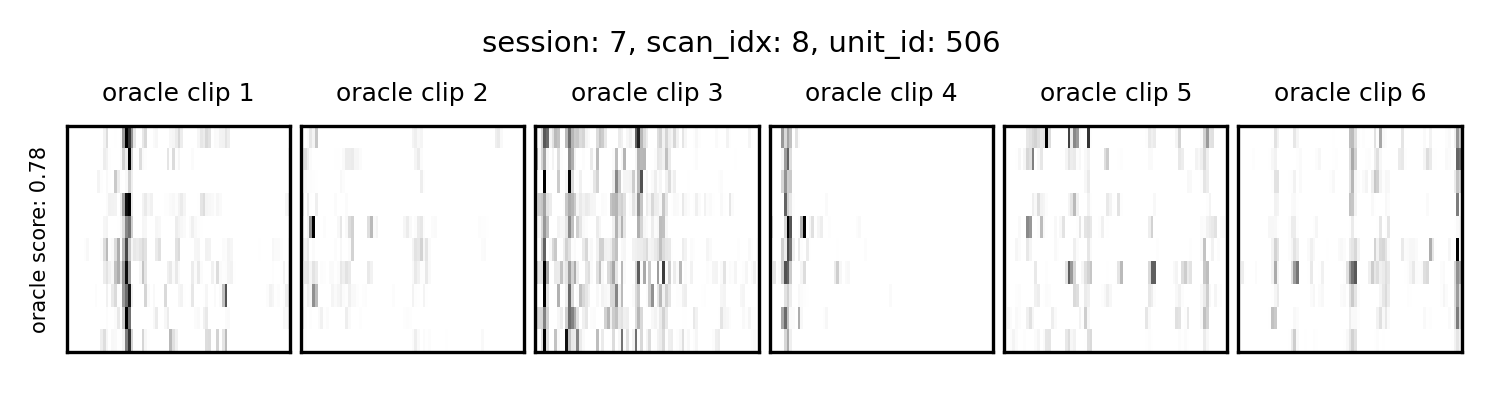

In [60]:
fig,axes = plt.subplots(1,6, figsize=(6,1),dpi=300)
for col,clip_trace in zip(axes,np.moveaxis(oracle_traces,1,0)):
    col.imshow(clip_trace,cmap='binary', interpolation='nearest')
    col.set_aspect('auto')
    col.set_xticks([])
    col.set_yticks([])
axes[0].set_ylabel(f'oracle score: {score:.2f}', fontsize=5)
fig.subplots_adjust(wspace=.05)
[ax.set_title(f'oracle clip {i+1}', fontsize=6) for i, ax in enumerate(axes)];
fig.suptitle(f'session: {unit_key["session"]}, scan_idx: {unit_key["scan_idx"]}, unit_id: {unit_key["unit_id"]}', fontsize=7, y=1.2)

### Spike traces

Spike traces are in `nda.Activity` and associated with single units (`unit_id's`).

In [61]:
nda.Activity() & unit_key

session Session ID,scan_idx Scan ID,unit_id unique per scan,trace spike trace
7,8,506,=BLOB=


In [62]:
spike_trace = (nda.Activity() & unit_key).fetch1('trace')

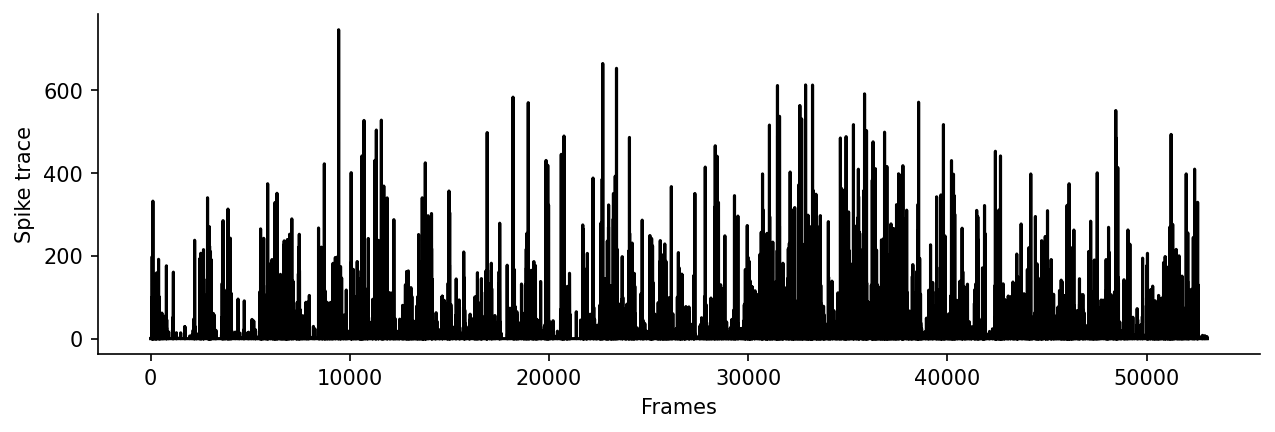

In [63]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(spike_trace, c='k')
ax.set_xlabel('Frames')
ax.set_ylabel('Spike trace')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

### View  fluorescence trace, and spike trace for the same unit

Use `nda.ScanUnit` to bridge between `unit_id` and `mask_id` to plot both the calcium trace spike trace and for a single unit.

In [64]:
nda.Fluorescence & (nda.ScanUnit & unit_key)

session Session ID,scan_idx Scan ID,field Field Number,"mask_id mask ID, unique per field",trace fluorescence trace
7,8,3,506,=BLOB=


In [65]:
calcium_trace = (nda.Fluorescence & (nda.ScanUnit & unit_key)).fetch1('trace')

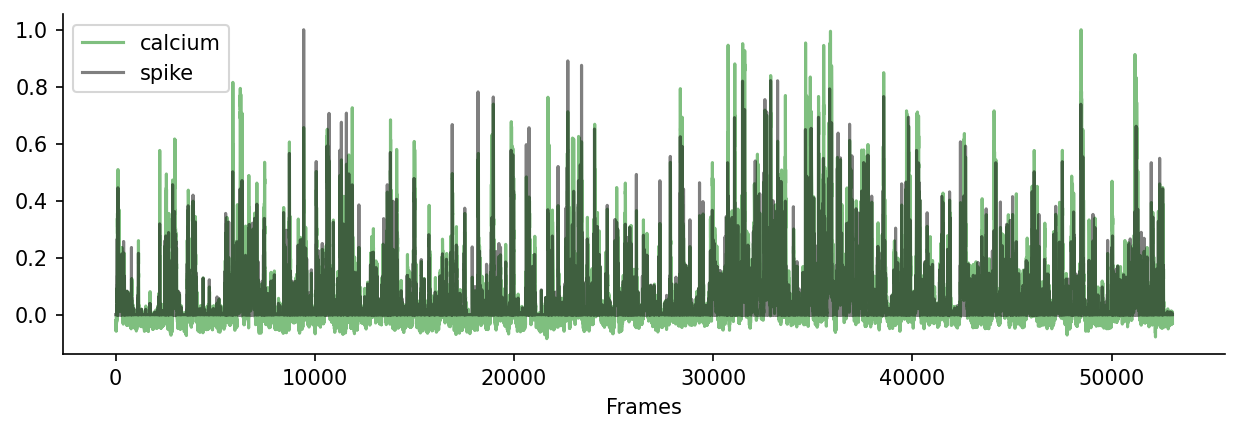

In [66]:
fig, ax = plt.subplots(figsize=(10, 3), dpi=150)
ax.plot(calcium_trace/ np.max(calcium_trace), c='g', alpha=0.5, label='calcium')
ax.plot(spike_trace/ np.max(spike_trace), c='k', label='spike', alpha=0.5)
ax.set_xlabel('Frames')
ax.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Field to Stack registration

A high spatial resolution structural 2P-Stack was acquired to serve as a common reference frame between the 2P functional imaging planes and the EM volume. Each imaging field was registered into the stack using affine registration learned via gradient ascent. For more detail see technical methods. 

### Stack information

The information on the structural 2P stack can be found in `nda.Stack`. `motor_x`, `motor_y`, `motor_z` store the center of the stack in the original acquisition coordinates. 

In [67]:
nda.Stack()

stack_session session ID,stack_idx stack ID,"motor_z center of volume in the motor coordinate system (microns, cortex at z=0)",motor_y center of volume in the motor coordinate system (microns),motor_x center of volume in the motor coordinate system (microns),px_depth number of slices,px_height lines per frame,px_width pixels per line,um_depth depth (microns),um_height height (microns),um_width width (microns),"surf_z depth of first slice - half a z step (microns, cortex is at z=0)"
9,11,254.0,-271.604,-266.514,275,646,652,550.0,807.5,815.0,-21.0


The affine matrix resulting from registration of each imaging field into the stack is located in `nda.Registration`. The attribute `reg_field` is the extracted stack image corresponding to the field grid after registration. In a good registration, the functional summary image in `nda.SummaryImages` and `reg_field` will be very similar. 

### Field registration

In [68]:
# affine matrix parameters for each field registered into the stack
nda.Registration & field_key

stack_session session ID,stack_idx stack ID,session Session ID,scan_idx Scan ID,field Field Number,"a11 row 1, column 1 of the affine matrix (microns)","a21 row 2, column 1 of the affine matrix (microns)","a31 row 3, column 1 of the affine matrix (microns)","a12 row 1, column 2 of the affine matrix (microns)","a22 row 2, column 2 of the affine matrix (microns)","a32 row 3, column 2 of the affine matrix (microns)",reg_x z translation (microns),reg_y y translation (microns),reg_z z translation (microns),score cross-correlation score (-1 to 1),reg_field extracted field from the stack in the specified position
9,11,7,8,4,1.00242,-0.00014893,0.0146511,0.00155005,1.00015,0.00227639,-250.379,-271.277,185.375,0.799769,=BLOB=


In [69]:
reg_field = (nda.Registration & field_key).fetch1('reg_field')

The functional summary image and registered stack field image are plotted for visual comparison. 

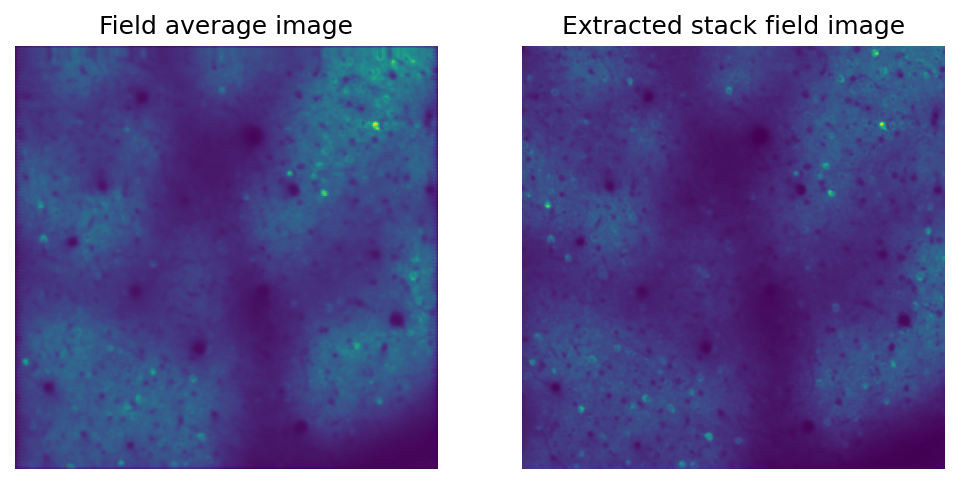

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(8,4), dpi=150)
axs[0].imshow(avg)
axs[0].set_title('Field average image')
axs[1].imshow(reg_field)
axs[1].set_title('Extracted stack field image')
[ax.axis('off') for ax in axs];